<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chargment-de-la-configuration" data-toc-modified-id="Chargment-de-la-configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Chargment de la configuration</a></span></li><li><span><a href="#Téléchargement-des-données" data-toc-modified-id="Téléchargement-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Téléchargement des données</a></span></li><li><span><a href="#Classification-des-images" data-toc-modified-id="Classification-des-images-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Classification des images</a></span></li><li><span><a href="#Segmentation-des-catalogues" data-toc-modified-id="Segmentation-des-catalogues-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Segmentation des catalogues</a></span></li></ul></div>

## Chargment de la configuration

In [1]:
from config import load_default_config
config = load_default_config('./data')
config['base_folder'] = './test'

## Téléchargement des données

Code pour télécharger les données depuis l'interface OAI-PMH de la bibliothèque numérique, les catalogues de ventes sont disponibles dans le set ```oai:sets:16800```.

Le code va télécharger toutes les métadonnées du set, et y sauver dans un fichier brut ```inha_bib_num_metadata.json.gz```, le code va également télécharger toutes les métadonées iiif correspondante pour également tout le set, vu que les informations de date et lieu sont mieux formatées dans ces dernière et va sauver ces informations dans le fichier ```iiif_manifests.json.gz```. Ces deux fichiers sont les portes d'entrées pour la collection et permettent de télécharger les fichiers d'images ainsi que d'obtenir toutes les métadonnées des catalogues de ventes.

Cette collection globale et les identifiants qui leur sont propres sont ensuite "mappé" vers une numérotation interne pour plus d'uniformité, les liens pour passer de l'un à l'autre se font aux travers de deux fichiers eux aussi sauvegardé sous la forme de jsons:
- ```idx2inhaIdx.json``` qui convertit de l'identifiant interne vers l'identifiant numérique unique de la bibliothèque numérique
- ```idx2cote.json``` qui convertit de l'identifiant interne vers la côte de la bibliothèque

Ces données sont plus ou moins fixes, mais changent à chaque fois que de nouveaux documents sont publiés sur la biblothèque numérique.

Un choix a été fait de ne se concentrer que sur la période 1939-1945 et sur la maison de vente Drouot afin d'avoir des documents relativement uniformes dans leur mise en page et un nombre relativement petit (1911 catalogues de vente). Ce choix est directement codé dans le code et n'offre pas d'options de configuration pour le changer.

Les métadonées sont donc filtrées pour le sous-set mentionné juste avant et les images sont automatiquement téléchargées avec comme convention de nommage 6 chiffres d'identifiant unique et 6 chiffres de pages. Donc par exemple pour la page 15 du document 1754, le fichier est ```001754_000014.jpg``` (14 car la numérotation commence à 0). Le nombre d'image avec ce filtre est d'environ 40'000 pour 1911 catalogues.

In [ ]:
from data_downloader.downloading_data import downloading_data
downloading_data(config)

La numérisation des images n’étant pas consistante, certains des images de catalogues contiennent deux pages et d’autre qu’une seule. Afin d'éviter toute erreur de classification sur cette étape, les images ont été triées à la mains (après une pré-classification réalisée avec des heuristiques simples), le temps pour trier les 40’000 pages étant relativement court (2 heures).

Les image qui contenaient deux pages ont ensuite simplement été coupées en deux, car la numérisation était bien alignée.

Il faut donc créer un fichier qui contient le chemin absolu vers les fichiers qui contiennent des pages doubles. Le code va ensuite couper ces images en deux et supprimer (!!!) l'original.

Si une image est coupée en deux, elle devient donc deux images avec le suffixe ```l``` si c'est l'image de gauche et ```r``` si c'est l'image de droite.

In [4]:
from data_downloader.cutting_pages import cutting_pages

config['data']['two_pages_path'] = 'path/to/two_pages_files.txt'

cutting_pages(config)

## Classification des images

Les pages de catalogues sont séparées en quatre typologies:
- **Information de ventes** (```sale_information```) qui correspond à une page de garde qui contient toutes les informations relative à la vente (date, lieu, contenue, expert, commissaire, etc.).
- **Description d’objets** (```objects_description```) qui correspond aux pages contenant les objets mis en vente.
- **Illustration** (```illustration```) qui correspond aux pages contenant des illustrations des objets mis en vente.
- **Autre** (```other```) qui correspond à toutes les autres pages.

Ces quatre typologie est un choix fait afin d'avoir à la fois une assez grande diversité visuelle pour que le classifier soit capable de distinguer entre les différentes classes et en même temps de pouvoir avoir la plupart des informations capitales pour un catalogue de vente à portée de main:
- Où sont les métadonnées de la vente ?
- Où sont les objets ?
- Où sont les éventuelles illustrations des ces objets ?

Environ 4’500 images ont été classifiées à la main. Plusieurs modèles de classification à base de CNN ont été testé avec plus ou moins de succès.

Le modèle qui a été retenu est un modèle basé sur un VGG16 pré-entraîné sur imagenet et qui utilise comme information le numéro de la page. Il a été entraîné sur un set de donnée de 3600 images et testé sur 900. Vu que le nombre d'exemple par classes est différent (majorité de descriptions d'objets), les données d'entraînement ont été sur-échantillonées afin de montrer un nombre égal d'image de chaque classe.

Les détails d'implémentations de l'entraînement ne sont pas montré ici. Le code a toutefois besoin d'un certain nombre d'images déjà annotées pour s'entraîner. Le format est un csv avec une colonne qui contient le nom de base de l'image (sans le chemin) et une deuxième colonne qui contient la classe (comme indiquée plus haut).

In [145]:
from classification.train import train
config['classification']['classification_csv'] = './classified_images.csv'
train(config)

Le code suivant montre la [matrice de confusion](https://fr.wikipedia.org/wiki/Matrice_de_confusion) du meilleur classifier.

Différents modèles ont été testé (VGG16, Resnet-50, Inception-Resnet V2) et on tous donnée des résultats similaires et très satisfaisant. Le choix du modèle c'est donc fait pour avoir un modèle plus stable avec moins de couches et qui donnait les meilleurs résultats sur les descriptions d'objets. En effet, les erreurs sur cette classes sont les plus pénalisantes, car c'est ce résultat là de la classification qui va se propager dans les étapes suivante. Toute page manquée résultera dans un manque d'objets et toute page ajoutée en trop ajouter du bruit au résultat final.

Avec le VGG16, nous pouvons donc voir qu'il y a très très peu d'erreurs et très peu de descriptions d'objets sont perdues (0.2%).

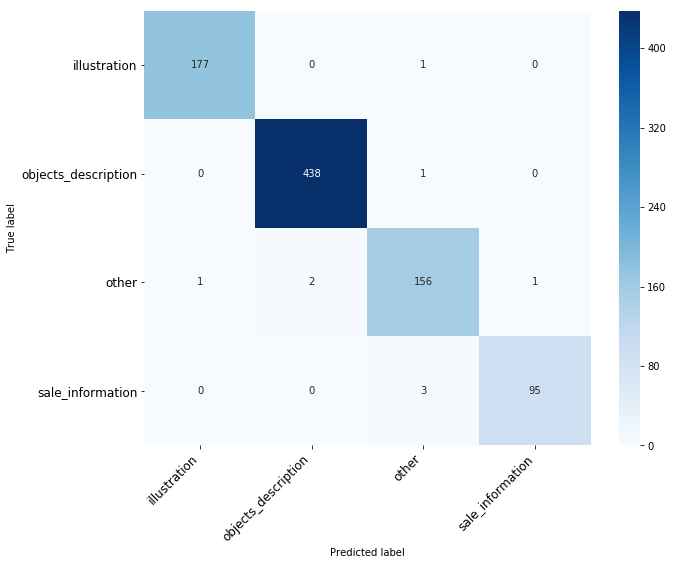

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = [[177,   0,   1,   0],
       [  0, 438,   1,   0],
       [  1,   2, 156,   1],
       [  0,   0,   3,  95]]
labels = ['illustration', 'objects_description', 'other', 'sale_information']

df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels, )
fig = plt.figure(figsize=(10,8))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label');

Une fois le modèle entraîné ou un modèle déjà entraîné télécharger, il est possible d'inférer les classes de nouvelles images.

Il faut toutefois connaître et paramétrer certaines informations, qui sont explicitées dans les commentaires plus bas.

Une fois de plus le code n'est pas explicité car il est standard et sans réel choix.

In [147]:
from classification.classify import classify

# Dossier contenant les images à annoter
images_folder = config['images_folder']

# Information sur le modèle
config['classification']['model_checkpoint_path'] = '/path/to/the/model.h5'
config['classification']['IMAGE_SIZE'] = (224, 224) # par défaut
config['classification']['use_page_num'] = True # par défaut
config['classification']['labels_txt_path'] = '/path/to/the/labels.txt' # généré par le code précédant

# Annotations manuelles
classification_csv = config['classification']['classification_csv']

# Csv qui contiendra les prédictions faites par le modèle
predicted_classes_csv = config['classification']['predicted_classes_csv']

classify(config)

## Segmentation des catalogues

In [150]:
from segmentation import prepare_dataset, create_masks, create_tf_dataset

In [154]:
prepare_dataset.prepare_dataset(config)












  0%|          | 0/6 [00:00<?, ?it/s]










100%|██████████| 6/6 [00:00<00:00, 259.48it/s]

### Loading jsons ###













  0%|          | 0/6 [00:00<?, ?it/s]










100%|██████████| 6/6 [00:00<00:00, 215.95it/s]










  0%|          | 0/6 [00:00<?, ?it/s]

### Loading images ###
### converting to grayscale ###













 50%|█████     | 3/6 [00:00<00:00, 24.71it/s]










100%|██████████| 6/6 [00:00<00:00, 23.01it/s]





















  0%|          | 0/6 [00:00<?, ?it/s]










 67%|██████▋   | 4/6 [00:00<00:00, 38.52it/s]

### Creating bounding boxes ###













100%|██████████| 6/6 [00:00<00:00, 29.08it/s]





















  0%|          | 0/6 [00:00<?, ?it/s]










100%|██████████| 6/6 [00:00<00:00, 366.90it/s]

### Creating ground truth ###


In [157]:
create_masks.create_masks(config)












  0%|          | 0/4 [00:00<?, ?it/s]










 75%|███████▌  | 3/4 [00:00<00:00, 29.09it/s]

### Processing training set ###













100%|██████████| 4/4 [00:00<00:00, 13.80it/s]










  0%|          | 0/2 [00:00<?, ?it/s]












### Processing testing set ###


100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

In [156]:
create_tf_dataset.create_tf_dataset(config)












  0%|          | 0/4 [00:00<?, ?it/s]










 50%|█████     | 2/4 [00:00<00:00, 17.53it/s]










100%|██████████| 4/4 [00:00<00:00, 18.11it/s]










  0%|          | 0/2 [00:00<?, ?it/s]










100%|██████████| 2/2 [00:00<00:00,  9.66it/s]












In [23]:
from segmentation.optimize_boxes_dhsegment import optimize_boxes_dhsegment


In [24]:
optimize_boxes_dhsegment(config)

  0%|          | 0/15 [00:00<?, ?it/s]         

1.0
Iteration No: 1 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.8272
Function value obtained: -0.2924
Current minimum: -0.2924
Iteration No: 2 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.3034
Function value obtained: -0.2535
Current minimum: -0.2924
Iteration No: 3 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.0667
Function value obtained: -0.4609
Current minimum: -0.4609
Iteration No: 4 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.5683
Function value obtained: -0.2924
Current minimum: -0.4609
Iteration No: 5 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.3552
Function value obtained: -0.4988
Current minimum: -0.4988
Iteration No: 6 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.3439
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 7 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 2.3698
Function value obtained: -0.3278
Current minimum: -0.6654
Iteration No: 8 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 2.7513
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 9 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.2859
Function value obtained: -0.1815
Current minimum: -0.6654
Iteration No: 10 started. Evaluating function at random point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.6125
Function value obtained: -0.4165
Current minimum: -0.6654
Iteration No: 11 started. Searching for the next optimal point.


 13%|█▎        | 2/15 [00:00<00:01, 12.30it/s] 

Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 1.7845
Function value obtained: -0.0000
Current minimum: -0.6654
Iteration No: 12 started. Searching for the next optimal point.


 13%|█▎        | 2/15 [00:00<00:01, 12.78it/s] 

Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1.3664
Function value obtained: -0.1111
Current minimum: -0.6654
Iteration No: 13 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1.1681
Function value obtained: -0.0000
Current minimum: -0.6654
Iteration No: 14 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 3.4433
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 15 started. Searching for the next optimal point.


 13%|█▎        | 2/15 [00:00<00:01, 10.62it/s] 

Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 3.1296
Function value obtained: -0.5988
Current minimum: -0.6654
Iteration No: 16 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.7145
Function value obtained: -0.2333
Current minimum: -0.6654
Iteration No: 17 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 3.5820
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 18 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 3.2990
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 19 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 3.5186
Function value obtained: -0.3442
Current minimum: -0.6654
Iteration No: 20 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 3.3263
Function value obtained: -0.3498
Current minimum: -0.6654
Iteration No: 21 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 3.4716
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 22 started. Searching for the next optimal point.


  7%|▋         | 1/15 [00:00<00:02,  5.40it/s] 

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 3.4258
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 23 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 2.5588
Function value obtained: -0.2619
Current minimum: -0.6654
Iteration No: 24 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 3.3617
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 25 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 3.4878
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 26 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 3.2980
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 27 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 2.9151
Function value obtained: -0.3848
Current minimum: -0.6654
Iteration No: 28 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 3.3209
Function value obtained: -0.6654
Current minimum: -0.6654
Iteration No: 29 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 3.1918
Function value obtained: -0.7778
Current minimum: -0.7778
Iteration No: 30 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.4509
Function value obtained: -0.7778
Current minimum: -0.7778
Iteration No: 31 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 3.5061
Function value obtained: -0.7778
Current minimum: -0.7778
Iteration No: 32 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 4.1299
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 33 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 3.3708
Function value obtained: -0.7778
Current minimum: -1.0000
Iteration No: 34 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 3.8728
Function value obtained: -0.8333
Current minimum: -1.0000
Iteration No: 35 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 3.7357
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 36 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.2740
Function value obtained: -0.8889
Current minimum: -1.0000
Iteration No: 37 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 3.3317
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 38 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 3.2770
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 39 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 3.2852
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 40 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 3.7349
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 41 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 3.8278
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 42 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 3.6374
Function value obtained: -0.7778
Current minimum: -1.0000
Iteration No: 43 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 3.6888
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 44 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 3.8670
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 45 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 3.4882
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 46 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 3.4077
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 47 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 3.7229
Function value obtained: -0.7000
Current minimum: -1.0000
Iteration No: 48 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 3.2009
Function value obtained: -0.6654
Current minimum: -1.0000
Iteration No: 49 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 3.7618
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 50 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 3.6965
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 51 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 3.8237
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 52 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 4.3235
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 53 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 3.6257
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 54 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 3.5105
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 55 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 3.4929
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 56 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 3.7310
Function value obtained: -0.8333
Current minimum: -1.0000
Iteration No: 57 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 3.8163
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 58 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 4.0438
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 59 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 3.5976
Function value obtained: -0.7778
Current minimum: -1.0000
Iteration No: 60 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 4.3051
Function value obtained: -0.7500
Current minimum: -1.0000
Iteration No: 61 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 3.8992
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 62 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 3.6794
Function value obtained: -0.7778
Current minimum: -1.0000
Iteration No: 63 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 3.8048
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 64 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 3.6778
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 65 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 3.6770
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 66 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 4.1003
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 67 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 3.5731
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 68 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 3.8043
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 69 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 3.9840
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 70 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 4.0593
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 71 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.8458
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 72 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 4.2594
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 73 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 4.4952
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 74 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 4.5520
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 75 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 3.8989
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 76 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 4.1788
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 77 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 3.7893
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 78 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 4.4848
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 79 started. Searching for the next optimal point.


  7%|▋         | 1/15 [00:00<00:01,  8.89it/s] 

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 4.2599
Function value obtained: -0.7778
Current minimum: -1.0000
Iteration No: 80 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 2.6316
Function value obtained: -0.5000
Current minimum: -1.0000
Iteration No: 81 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 4.0282
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 82 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 4.2393
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 83 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 4.2170
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 84 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.9358
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 85 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 4.0988
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 86 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 4.8520
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 87 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 4.4233
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 88 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 4.8754
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 89 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 4.2796
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 90 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 4.0423
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 91 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 4.7040
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 92 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 4.3488
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 93 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 4.8770
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 94 started. Searching for the next optimal point.


 13%|█▎        | 2/15 [00:00<00:01, 11.09it/s] 

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 4.5733
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 95 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 3.0945
Function value obtained: -0.5000
Current minimum: -1.0000
Iteration No: 96 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 5.2743
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 97 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 4.8673
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 98 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 5.1526
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 99 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 4.8538
Function value obtained: -1.0000
Current minimum: -1.0000
Iteration No: 100 started. Searching for the next optimal point.


  0%|          | 0/15 [00:00<?, ?it/s]         

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 5.1435
Function value obtained: -1.0000
Current minimum: -1.0000
[0.8803364512600322, 0.45748651823813336, 30, 0, 4, 100, 0.05, 969, 1895]


1.0


In [6]:
from segmentation.optimize_boxes_faster_rcnn import optimize_boxes_faster_rcnn

In [12]:
optimize_boxes_faster_rcnn(config)


  2%|▏         | 15/1000 [00:00<00:06, 147.36it/s]

### Loading jsons ###



 27%|██▋       | 269/1000 [00:26<13:09,  1.08s/it]

KeyboardInterrupt: 

In [13]:
from segmentation.predict_boxes import predict_boxes

In [ ]:
predict_boxes(config)

### Predicting images ###







  0%|          | 0/32288 [00:00<?, ?it/s]




  0%|          | 1/32288 [00:00<6:40:08,  1.34it/s]




  0%|          | 2/32288 [00:02<10:10:45,  1.14s/it]




  0%|          | 5/32288 [00:03<7:19:58,  1.22it/s] 




  0%|          | 8/32288 [00:03<5:26:59,  1.65it/s]




  0%|          | 18/32288 [00:04<4:02:39,  2.22it/s]




  0%|          | 19/32288 [00:04<3:13:53,  2.77it/s]




  0%|          | 20/32288 [00:04<3:20:13,  2.69it/s]




  0%|          | 23/32288 [00:06<3:34:53,  2.50it/s]




  0%|          | 26/32288 [00:06<2:57:45,  3.02it/s]




  0%|          | 31/32288 [00:07<2:19:59,  3.84it/s]




  0%|          | 34/32288 [00:08<2:38:29,  3.39it/s]




  0%|          | 35/32288 [00:09<5:47:20,  1.55it/s]




  0%|          | 36/32288 [00:10<6:08:00,  1.46it/s]




  0%|          | 59/32288 [00:11<4:21:00,  2.06it/s]




  0%|          | 61/32288 [00:11<3:13:02,  2.78it/s]




  0%|          | 63/32288 [00:11<2:38:20,  3.39it/s]




  0%|          | 66/32288 [00:13<3:43:3

  6%|▌         | 1782/32288 [04:11<3:25:12,  2.48it/s]




  6%|▌         | 1804/32288 [04:12<2:28:16,  3.43it/s]




  6%|▌         | 1809/32288 [04:12<1:48:11,  4.69it/s]




  6%|▌         | 1812/32288 [04:12<1:42:38,  4.95it/s]




  6%|▌         | 1814/32288 [04:14<3:22:03,  2.51it/s]




  6%|▌         | 1817/32288 [04:15<3:13:01,  2.63it/s]




  6%|▌         | 1819/32288 [04:15<2:35:30,  3.27it/s]




  6%|▌         | 1824/32288 [04:17<2:50:14,  2.98it/s]




  6%|▌         | 1825/32288 [04:18<3:11:59,  2.64it/s]




  6%|▌         | 1827/32288 [04:18<2:35:05,  3.27it/s]




  6%|▌         | 1830/32288 [04:19<2:21:58,  3.58it/s]




  6%|▌         | 1831/32288 [04:20<4:25:36,  1.91it/s]




  6%|▌         | 1834/32288 [04:20<3:11:25,  2.65it/s]




  6%|▌         | 1836/32288 [04:20<2:47:00,  3.04it/s]




  6%|▌         | 1839/32288 [04:21<2:19:16,  3.64it/s]




  6%|▌         | 1840/32288 [04:21<2:51:07,  2.97it/s]




  6%|▌         | 1844/32288 [04:23<2:59:41,  2.82it/s]



 11%|█         | 3439/32288 [06:34<56:59,  8.44it/s]




 11%|█         | 3444/32288 [06:38<2:30:36,  3.19it/s]




 11%|█         | 3448/32288 [06:39<2:16:38,  3.52it/s]




 11%|█         | 3451/32288 [06:40<2:15:45,  3.54it/s]




 11%|█         | 3453/32288 [06:40<2:19:27,  3.45it/s]




 11%|█         | 3456/32288 [06:42<3:15:40,  2.46it/s]




 11%|█         | 3458/32288 [06:43<3:01:15,  2.65it/s]




 11%|█         | 3493/32288 [06:43<2:07:11,  3.77it/s]




 11%|█         | 3529/32288 [06:45<1:37:08,  4.93it/s]




 11%|█         | 3537/32288 [06:53<3:35:55,  2.22it/s]




 11%|█         | 3543/32288 [06:55<3:17:01,  2.43it/s]




 11%|█         | 3547/32288 [06:58<4:00:35,  1.99it/s]




 11%|█         | 3550/32288 [07:00<4:15:48,  1.87it/s]




 11%|█         | 3552/32288 [07:00<3:38:10,  2.20it/s]




 11%|█         | 3554/32288 [07:01<3:16:12,  2.44it/s]




 11%|█         | 3556/32288 [07:01<2:26:11,  3.28it/s]




 11%|█         | 3558/32288 [07:03<4:09:47,  1.92it/s]





 19%|█▉        | 6129/32288 [11:37<2:31:05,  2.89it/s]




 19%|█▉        | 6131/32288 [11:40<4:17:17,  1.69it/s]




 19%|█▉        | 6213/32288 [11:40<2:59:42,  2.42it/s]




 19%|█▉        | 6239/32288 [11:40<2:09:07,  3.36it/s]




 19%|█▉        | 6296/32288 [11:41<1:30:25,  4.79it/s]




 20%|█▉        | 6363/32288 [11:43<1:07:23,  6.41it/s]




 20%|█▉        | 6385/32288 [11:48<1:15:59,  5.68it/s]




 20%|█▉        | 6401/32288 [11:52<1:24:52,  5.08it/s]




 20%|█▉        | 6412/32288 [11:53<1:14:33,  5.78it/s]




 20%|█▉        | 6420/32288 [11:54<1:17:04,  5.59it/s]




 20%|█▉        | 6426/32288 [11:59<2:33:56,  2.80it/s]




 20%|█▉        | 6431/32288 [12:01<2:42:20,  2.65it/s]




 20%|█▉        | 6434/32288 [12:02<2:24:57,  2.97it/s]




 20%|█▉        | 6437/32288 [12:03<2:11:07,  3.29it/s]




 20%|█▉        | 6439/32288 [12:03<1:50:35,  3.90it/s]




 20%|█▉        | 6441/32288 [12:03<1:25:10,  5.06it/s]




 20%|█▉        | 6443/32288 [12:03<1:21:55,  5.26it/s]



 28%|██▊       | 9011/32288 [16:52<1:43:28,  3.75it/s]




 28%|██▊       | 9034/32288 [16:52<1:13:05,  5.30it/s]




 28%|██▊       | 9110/32288 [16:53<51:55,  7.44it/s]  




 28%|██▊       | 9172/32288 [16:55<38:58,  9.88it/s]




 28%|██▊       | 9181/32288 [16:59<1:28:47,  4.34it/s]




 28%|██▊       | 9188/32288 [17:04<2:22:01,  2.71it/s]




 28%|██▊       | 9193/32288 [17:06<2:27:30,  2.61it/s]




 28%|██▊       | 9197/32288 [17:08<2:30:25,  2.56it/s]




 28%|██▊       | 9200/32288 [17:09<2:43:15,  2.36it/s]




 28%|██▊       | 9202/32288 [17:10<2:04:35,  3.09it/s]




 29%|██▊       | 9204/32288 [17:11<2:55:25,  2.19it/s]




 29%|██▊       | 9206/32288 [17:13<3:40:43,  1.74it/s]




 29%|██▊       | 9207/32288 [17:13<3:22:11,  1.90it/s]




 29%|██▊       | 9208/32288 [17:15<6:16:02,  1.02it/s]




 29%|██▊       | 9264/32288 [17:15<4:22:47,  1.46it/s]




 29%|██▊       | 9282/32288 [17:18<3:22:18,  1.90it/s]




 29%|██▉       | 9295/32288 [17:20<2:40:21,  2.39it/s]





 37%|███▋      | 11925/32288 [21:50<4:14:32,  1.33it/s]




 37%|███▋      | 11926/32288 [21:50<3:26:45,  1.64it/s]




 37%|███▋      | 11927/32288 [21:51<3:11:15,  1.77it/s]




 37%|███▋      | 11928/32288 [21:53<5:40:24,  1.00s/it]




 37%|███▋      | 11929/32288 [21:53<4:23:38,  1.29it/s]




 37%|███▋      | 11943/32288 [21:55<3:18:00,  1.71it/s]




 37%|███▋      | 11944/32288 [21:56<4:17:10,  1.32it/s]




 37%|███▋      | 11948/32288 [21:58<3:47:01,  1.49it/s]




 37%|███▋      | 11949/32288 [21:58<2:56:09,  1.92it/s]




 37%|███▋      | 11951/32288 [21:59<2:36:11,  2.17it/s]




 37%|███▋      | 11952/32288 [22:00<4:08:18,  1.37it/s]




 37%|███▋      | 11953/32288 [22:01<3:39:57,  1.54it/s]




 37%|███▋      | 11967/32288 [22:02<2:41:05,  2.10it/s]




 37%|███▋      | 11970/32288 [22:02<2:01:46,  2.78it/s]




 37%|███▋      | 11971/32288 [22:03<3:33:08,  1.59it/s]




 37%|███▋      | 11975/32288 [22:04<2:42:30,  2.08it/s]




 37%|███▋      | 11976/32288 [22:04<3:08

 44%|████▎     | 14120/32288 [26:44<2:45:30,  1.83it/s]




 44%|████▎     | 14124/32288 [26:44<2:17:03,  2.21it/s]




 44%|████▍     | 14127/32288 [26:45<1:39:24,  3.04it/s]




 44%|████▍     | 14130/32288 [26:47<2:14:52,  2.24it/s]




 44%|████▍     | 14132/32288 [26:49<3:05:35,  1.63it/s]




 44%|████▍     | 14135/32288 [26:51<3:11:23,  1.58it/s]




 44%|████▍     | 14136/32288 [26:51<2:27:06,  2.06it/s]




 44%|████▍     | 14139/32288 [26:52<2:01:46,  2.48it/s]




 44%|████▍     | 14142/32288 [26:53<1:54:57,  2.63it/s]




 44%|████▍     | 14143/32288 [26:53<2:21:43,  2.13it/s]




 44%|████▍     | 14144/32288 [26:55<4:39:52,  1.08it/s]




 44%|████▍     | 14147/32288 [26:55<3:19:39,  1.51it/s]




 44%|████▍     | 14148/32288 [26:57<4:55:27,  1.02it/s]




 44%|████▍     | 14151/32288 [26:57<3:37:52,  1.39it/s]




 44%|████▍     | 14152/32288 [26:57<2:42:34,  1.86it/s]




 44%|████▍     | 14156/32288 [26:58<2:10:43,  2.31it/s]




 44%|████▍     | 14170/32288 [27:00<1:40

 51%|█████     | 16511/32288 [30:51<1:46:58,  2.46it/s]




 51%|█████     | 16524/32288 [30:54<1:31:38,  2.87it/s]




 51%|█████     | 16527/32288 [30:55<1:23:23,  3.15it/s]




 51%|█████     | 16529/32288 [30:55<1:05:55,  3.98it/s]




 51%|█████     | 16536/32288 [30:55<47:20,  5.54it/s]  




 51%|█████     | 16539/32288 [30:56<41:13,  6.37it/s]




 51%|█████     | 16542/32288 [30:56<36:09,  7.26it/s]




 51%|█████     | 16544/32288 [30:59<2:21:38,  1.85it/s]




 51%|█████     | 16546/32288 [31:01<2:59:49,  1.46it/s]




 51%|█████▏    | 16548/32288 [31:03<3:25:50,  1.27it/s]




 51%|█████▏    | 16549/32288 [31:04<3:15:04,  1.34it/s]




 51%|█████▏    | 16550/32288 [31:04<3:13:25,  1.36it/s]




 51%|█████▏    | 16617/32288 [31:04<2:14:56,  1.94it/s]




 52%|█████▏    | 16649/32288 [31:06<1:36:59,  2.69it/s]




 52%|█████▏    | 16669/32288 [31:08<1:18:58,  3.30it/s]




 52%|█████▏    | 16680/32288 [31:11<1:14:31,  3.49it/s]




 52%|█████▏    | 16688/32288 [31:14<1:25:07,

 62%|██████▏   | 19986/32288 [35:25<1:08:07,  3.01it/s]




 62%|██████▏   | 19989/32288 [35:25<57:13,  3.58it/s]  




 62%|██████▏   | 19990/32288 [35:25<49:26,  4.15it/s]




 62%|██████▏   | 19993/32288 [35:27<59:28,  3.45it/s]




 62%|██████▏   | 19994/32288 [35:27<1:03:09,  3.24it/s]




 62%|██████▏   | 19998/32288 [35:28<56:59,  3.59it/s]  




 62%|██████▏   | 19999/32288 [35:28<1:15:13,  2.72it/s]




 62%|██████▏   | 20003/32288 [35:29<1:03:54,  3.20it/s]




 62%|██████▏   | 20004/32288 [35:29<1:12:44,  2.81it/s]




 62%|██████▏   | 20005/32288 [35:30<1:10:29,  2.90it/s]




 62%|██████▏   | 20006/32288 [35:31<2:02:01,  1.68it/s]




 62%|██████▏   | 20010/32288 [35:31<1:28:27,  2.31it/s]




 62%|██████▏   | 20011/32288 [35:32<1:45:53,  1.93it/s]




 62%|██████▏   | 20015/32288 [35:33<1:26:14,  2.37it/s]




 62%|██████▏   | 20018/32288 [35:34<1:31:42,  2.23it/s]




 62%|██████▏   | 20019/32288 [35:35<1:22:28,  2.48it/s]




 62%|██████▏   | 20035/32288 [35:35<1:00:53,

In [37]:
from database.extract_page_content import extract_page_content

In [38]:
extract_page_content(config)




  0%|          | 0/107 [00:00<?, ?it/s]

### Extracting page content ###





  1%|          | 1/107 [00:00<01:33,  1.14it/s]


  2%|▏         | 2/107 [00:01<01:14,  1.40it/s]


  3%|▎         | 3/107 [00:01<01:03,  1.63it/s]


  4%|▎         | 4/107 [00:01<00:55,  1.86it/s]


  5%|▍         | 5/107 [00:03<01:12,  1.41it/s]


  6%|▌         | 6/107 [00:03<01:00,  1.66it/s]


  7%|▋         | 7/107 [00:04<01:04,  1.55it/s]


  7%|▋         | 8/107 [00:04<00:51,  1.93it/s]


  8%|▊         | 9/107 [00:04<00:45,  2.14it/s]


  9%|▉         | 10/107 [00:05<00:46,  2.08it/s]


 10%|█         | 11/107 [00:06<01:03,  1.52it/s]


 11%|█         | 12/107 [00:06<00:54,  1.75it/s]


 12%|█▏        | 13/107 [00:07<01:14,  1.27it/s]


 13%|█▎        | 14/107 [00:09<01:20,  1.15it/s]


 14%|█▍        | 15/107 [00:10<01:27,  1.05it/s]


 15%|█▍        | 16/107 [00:10<01:14,  1.23it/s]


 17%|█▋        | 18/107 [00:11<00:55,  1.61it/s]


 18%|█▊        | 19/107 [00:11<00:48,  1.81it/s]


 19%|█▊        | 20/107 [00:12<00:55,  1.57it/s]


 20%|█▉        | 21/107 [00:12<00:48,

### Correcting sale references ###
### Creating section hiearchy ###





 12%|█▏        | 5/42 [00:00<00:00, 42.55it/s]


 21%|██▏       | 9/42 [00:00<00:00, 40.86it/s]


 31%|███       | 13/42 [00:00<00:00, 40.39it/s]


 38%|███▊      | 16/42 [00:00<00:00, 36.26it/s]


 45%|████▌     | 19/42 [00:00<00:00, 29.33it/s]


 52%|█████▏    | 22/42 [00:00<00:00, 26.52it/s]


 60%|█████▉    | 25/42 [00:00<00:00, 25.17it/s]


 67%|██████▋   | 28/42 [00:00<00:00, 24.55it/s]


 74%|███████▍  | 31/42 [00:01<00:00, 23.96it/s]


 81%|████████  | 34/42 [00:01<00:00, 23.66it/s]


 88%|████████▊ | 37/42 [00:01<00:00, 23.35it/s]


 95%|█████████▌| 40/42 [00:01<00:00, 23.16it/s]


100%|██████████| 42/42 [00:01<00:00, 25.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 149.47it/s]

### Creating section hierachy tree ###


In [45]:
from database.prepare_data_for_sql import prepare_data_for_sql

In [46]:
prepare_data_for_sql(config)

### Loading data utils ###
### Actor table ###





  0%|          | 0/4 [00:00<?, ?it/s]


100%|██████████| 4/4 [00:00<00:00, 5344.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]


 75%|███████▌  | 3/4 [00:00<00:00, 29.15it/s]


100%|██████████| 4/4 [00:00<00:00, 36.32it/s]

### Sale table ###
### Actor Sale table ###
### Section table ###
### Object table table ###





  0%|          | 0/712 [00:00<?, ?it/s]


100%|██████████| 712/712 [00:00<00:00, 37864.62it/s]


  0%|          | 0/712 [00:00<?, ?it/s]


100%|██████████| 712/712 [00:00<00:00, 21831.28it/s]

In [47]:
import pandas as pd

In [50]:
pd.read_csv('/scratch/raphael/test/sql_csv/object_table.csv')

,sale_id,page,entity,parent_section_sale,parent_section_page,parent_section_entity,num_ref,text,bbox,inha_url,iif_url
0,1787,0.00,4,NaN,NaN,NaN,NaN,Vente du 9 Février 1940\n,"(262, 1165, 621, 1210)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
1,1787,1.75,4,NaN,NaN,NaN,NaN,Assisté de :,"(362, 982, 481, 1010)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
2,1787,1.75,5,NaN,NaN,NaN,NaN,Pour les Tableaux modernes\nPour les Objets d'...,"(121, 1023, 745, 1106)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
3,1787,1.75,6,NaN,NaN,NaN,NaN,"EXPOSITION PUBLIQUE Le Jeudi 8 FÉVRIER 1940, d...","(94, 1149, 744, 1214)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
4,1787,2.25,0,NaN,NaN,NaN,NaN,CONDITIONS DE LA VENTE\n,"(268, 419, 639, 451)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
5,1787,2.25,1,NaN,NaN,NaN,NaN,Elle aura lieu au comptant.\nLes adjudicataire...,"(182, 515, 730, 704)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
6,1787,2.75,3,1787.0,2.75,2.0,1.0,1. — Dessins faits sur une nappe de la\n« Mais...,"(180, 490, 689, 550)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
7,1787,2.75,5,1787.0,2.75,4.0,2.0,2. — Espagnole.\nPastel.\n,"(173, 609, 371, 671)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
8,1787,2.75,7,1787.0,2.75,6.0,3.0,3. — Fleurs.\nToile.\n,"(174, 732, 325, 792)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...
9,1787,2.75,9,1787.0,2.75,6.0,4.0,"4. — Géraniums.\nToile, signée à droite.\n","(171, 852, 512, 912)",https://bibliotheque-numerique.inha.frviewer/2...,https://bibliotheque-numerique.inha.fr/i/?IIIF...


In [ ]:
export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim